In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import numpy.ma as ma

from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

def call_dataset(game_name):
	# load data
	game_csv = game_name
	data = pd.read_csv(f'datasets/{game_csv}_tweets_datatset.csv',lineterminator='\n')

	data = data[data['text'].str.contains('I liked a YouTube')== False]
	data = data[data['text'].str.contains('I liked a @YouTube video')== False]
	data = data[data['text'].str.contains('I added a video to a @YouTube')== False]
	data = data[data['text'].str.contains('I added a video to a YouTube')== False]
	data = data[data['text'].str.contains('Giveaway')== False]

	# removing \r in 'sentiment'
	if 'sentiment\r' in data.columns:
		data['sentiment'] = data['sentiment\r'].apply(lambda x: x.replace('\r',''))
		data.drop(columns=['sentiment\r'],inplace=True)
	
	# removing first columns
	data.drop(data.columns[0], axis=1, inplace=True)

	# changing 'sentiment scores' from str to ndarray
	data['sentiment scores'] = data['sentiment scores'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

	# changing 'tweet id' from float64 to str
	data['tweet id'] = data['tweet id'].apply(lambda x: str(int(x)))

	# adding sentiment scores
	sentiment_score = []
	sentiment_confidence = []
	for score in data['sentiment scores']:
		sentiment_score.append(score.argmax())
		sentiment_confidence.append(score[score.argmax()])
	
	data['sentiment score'] = sentiment_score
	data['sentiment confidence'] = sentiment_confidence

	# changing 'created at' date from str to datetime	
	data['created at'] = data['created at'].apply(lambda x: x.removesuffix('+00:00'))
	data['created at'] = data['created at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
	data['date'] = data['created at'].apply(lambda x: datetime.date(x))
	
	# sorting from earliest to latest
	data.sort_values(by='created at', inplace=True)
	data.reset_index(drop=True, inplace=True)
	return data

In [3]:
def sentiment_figure(game_dataset):
    sentiment_per_day = game_dataset.groupby(['sentiment','date'], as_index=False).size()
    return sentiment_per_day

In [2]:
xy = call_dataset('xy')
oras = call_dataset('oras')
sunmoon = call_dataset('sunmoon')
ultrasm = call_dataset('ultrasm')
letsgo = call_dataset('letsgo')
swsh = call_dataset('swsh')
swshdlc = call_dataset('swshdlc')
bdsp = call_dataset('bdsp')
arceus = call_dataset('arceus')
sv = call_dataset('sv')

In [68]:
frames_list = [xy, oras, sunmoon, ultrasm, letsgo, swsh, swshdlc, bdsp, arceus, sv]
all_games = pd.concat(frames_list)

In [69]:
all_s = sentiment_figure(all_games)
only_positive = all_s[all_s['sentiment']=="Positive"]
only_negative = all_s[all_s['sentiment']=="Negative"]
only_neutral  = all_s[all_s['sentiment']=="Neutral"]

In [70]:
only_positive = only_positive.drop(columns='sentiment')
only_negative = only_negative.drop(columns='sentiment')
only_neutral  = only_neutral.drop(columns='sentiment')

# Changing Column Names for FB Prophet

In [71]:
only_positive.columns = ['ds','y']
only_negative.columns = ['ds','y']
only_neutral.columns  = ['ds','y']

In [72]:
only_positive.reset_index(drop=True,inplace=True)
only_negative.reset_index(drop=True,inplace=True)
only_neutral.reset_index(drop=True,inplace=True)

# Train Test Split

In [73]:
train = only_positive.iloc[:len(only_positive)-365]
test = only_positive.iloc[len(only_positive)-365:]

# Making Predictions

In [74]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=800) #MS for monthly, H for hourly
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.28235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4335.29   0.000841028       136.764       1.542      0.1542      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4336.61   0.000217804       69.6016           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4336.94   0.000235792       74.5205       0.832       0.832      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4337.12   1.38159e-05       64.3661      0.5716      0.5716      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     444       4337.12   6.91962e-06       71.5631   1.019e-07       0.001      599  LS failed, Hessian reset 
     499       4337.13   2.19311e-05    

In [75]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2583,2023-09-13,309.318509,-862.305408,1504.474704
2584,2023-09-14,289.708466,-958.215342,1518.609194
2585,2023-09-15,433.048472,-724.118024,1599.085182
2586,2023-09-16,239.726286,-1038.372756,1505.660965
2587,2023-09-17,136.389319,-1030.584354,1297.697200


<AxesSubplot:xlabel='ds'>

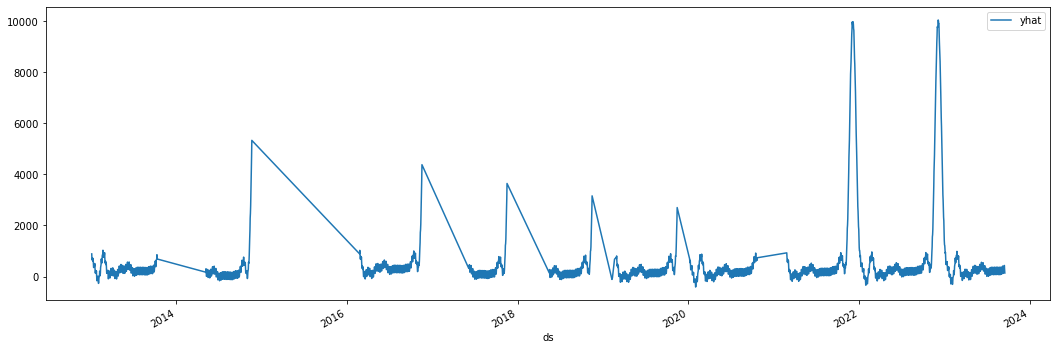

In [77]:
forecast.plot(x='ds',y='yhat',figsize=(18,6))

<AxesSubplot:xlabel='ds'>

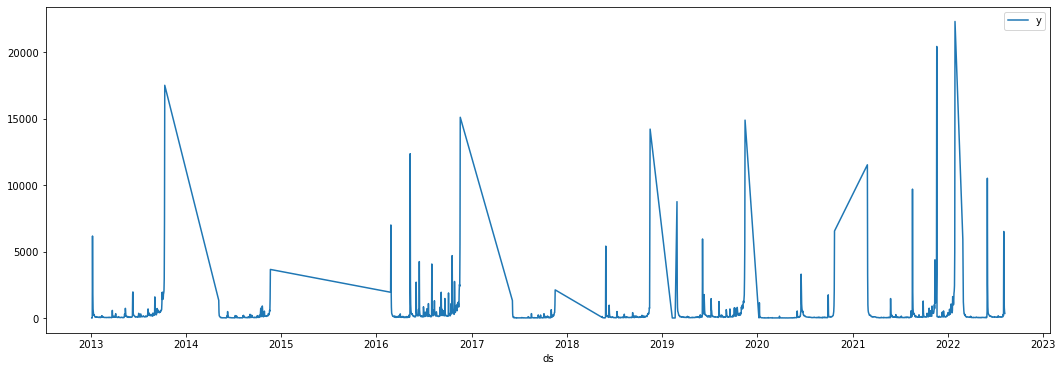

In [78]:
only_positive.plot(x='ds',y='y',figsize=(18,6))

In [79]:
plot_plotly(m ,forecast)

In [80]:
plot_components_plotly(m, forecast)